In [1]:
from sklearn.utils import shuffle
from sklearn.model_selection import GroupKFold

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

import numpy as np
import math, os
import load_data

modal_list = ['FLAIR','T1', 'T1post','T2']

import file_structure




texture train/test fold: 0
texture train/test fold: 1
texture train/test fold: 2
texture train/test fold: 3
texture train/test fold: 4
texture train/test fold: 5
texture train/test fold: 6
texture train/test fold: 7
texture train/test fold: 8
texture train/test fold: 9


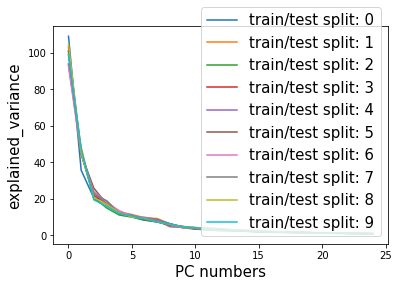

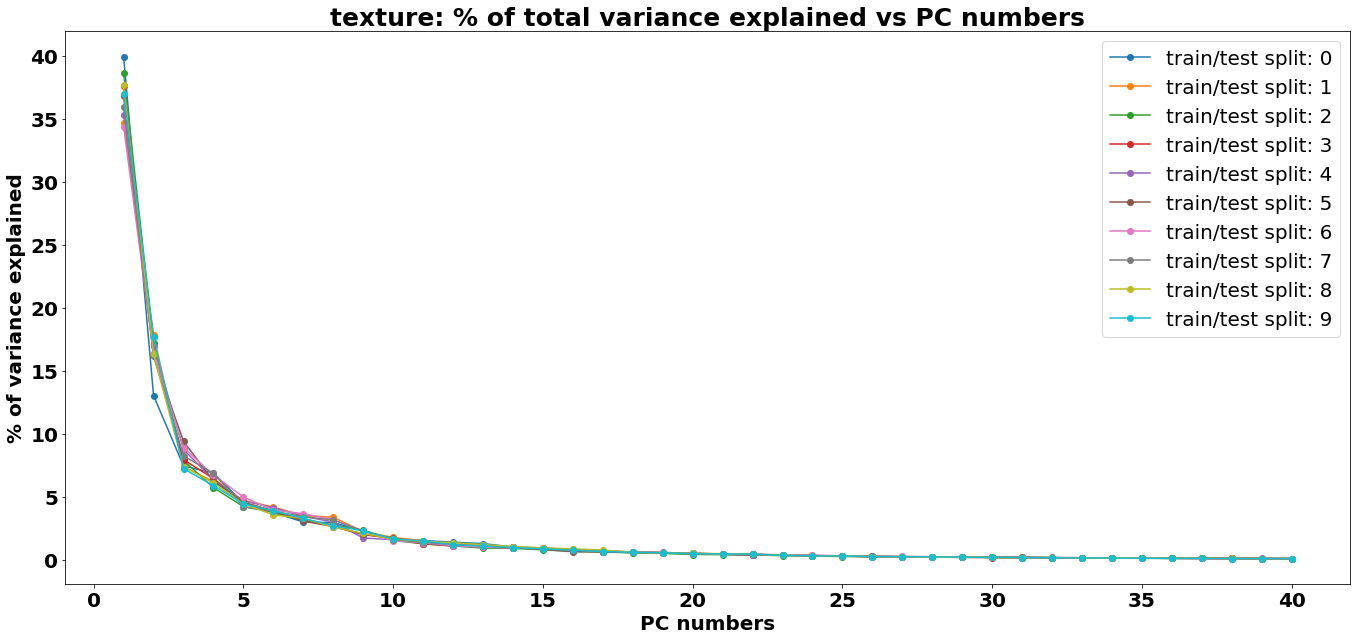

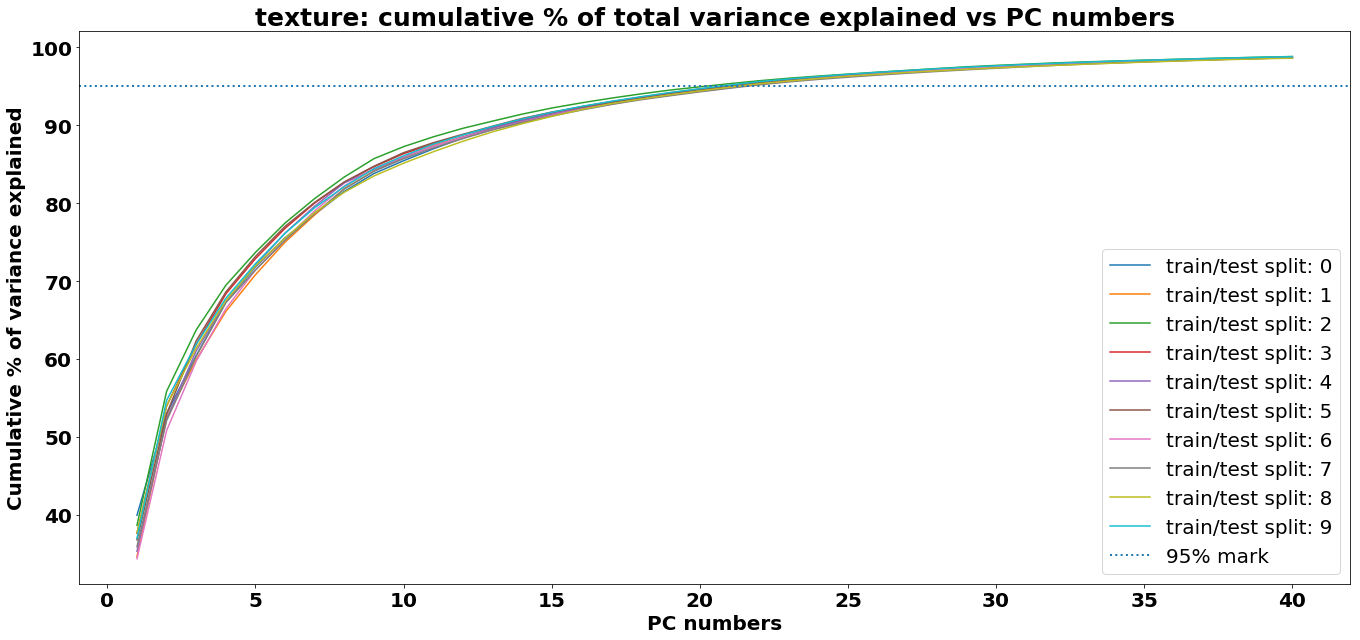

texture: Mean 95th perc. cutoff: 20.3
TDA train/test fold: 0
TDA train/test fold: 1
TDA train/test fold: 2
TDA train/test fold: 3
TDA train/test fold: 4
TDA train/test fold: 5
TDA train/test fold: 6
TDA train/test fold: 7
TDA train/test fold: 8
TDA train/test fold: 9


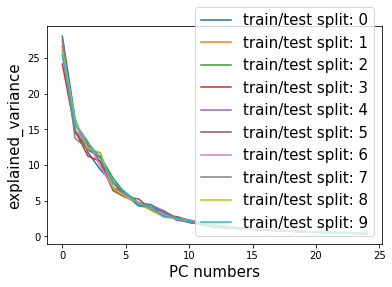

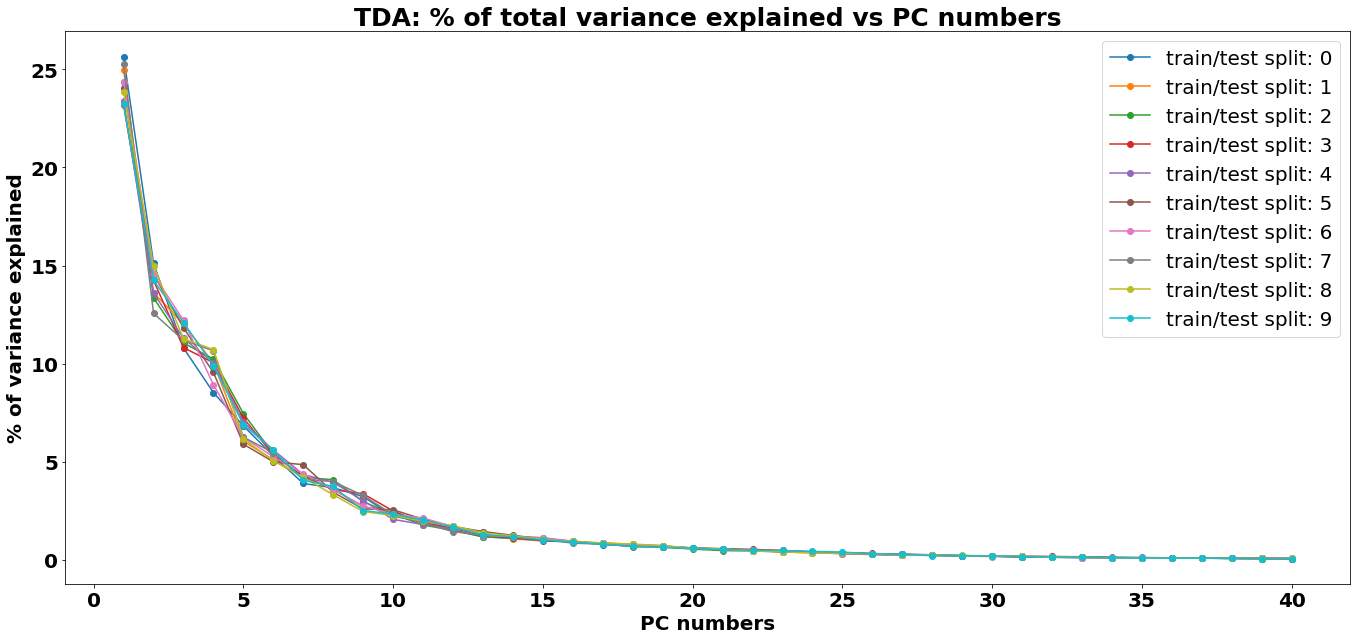

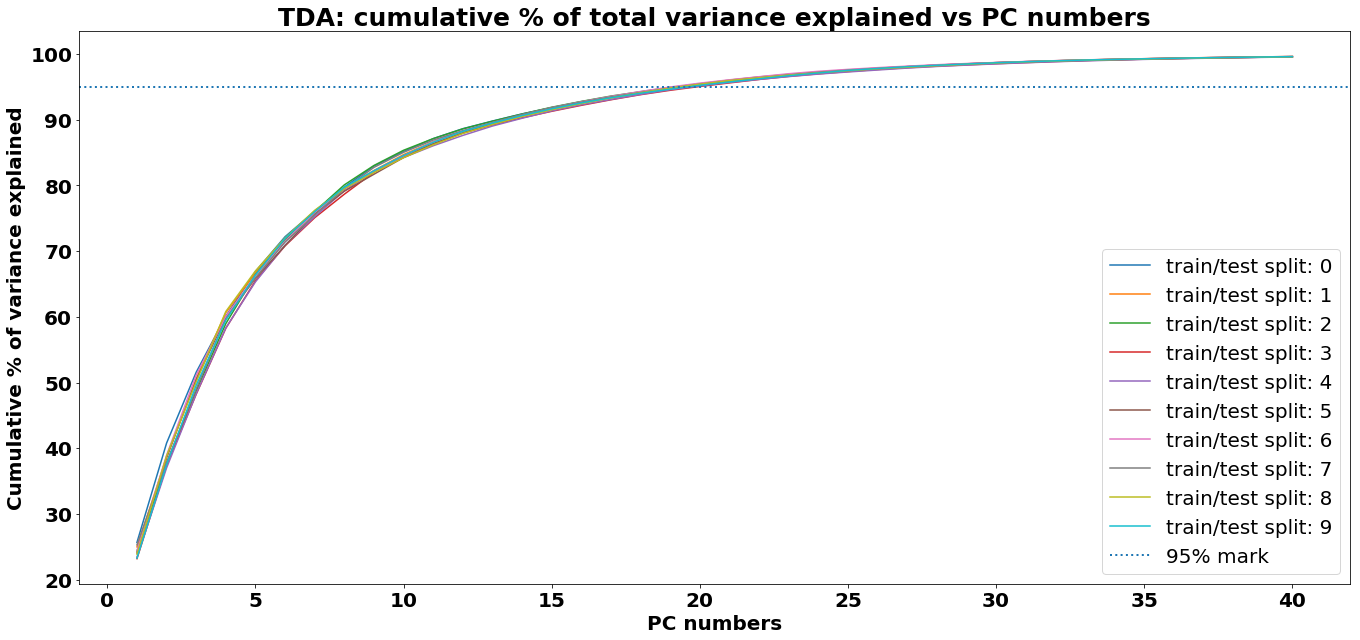

TDA: Mean 95th perc. cutoff: 19
CNN train/test fold: 0
CNN train/test fold: 1
CNN train/test fold: 2
CNN train/test fold: 3
CNN train/test fold: 4
CNN train/test fold: 5
CNN train/test fold: 6
CNN train/test fold: 7
CNN train/test fold: 8
CNN train/test fold: 9


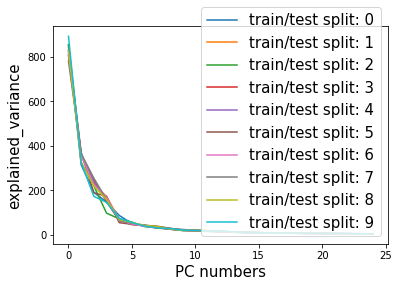

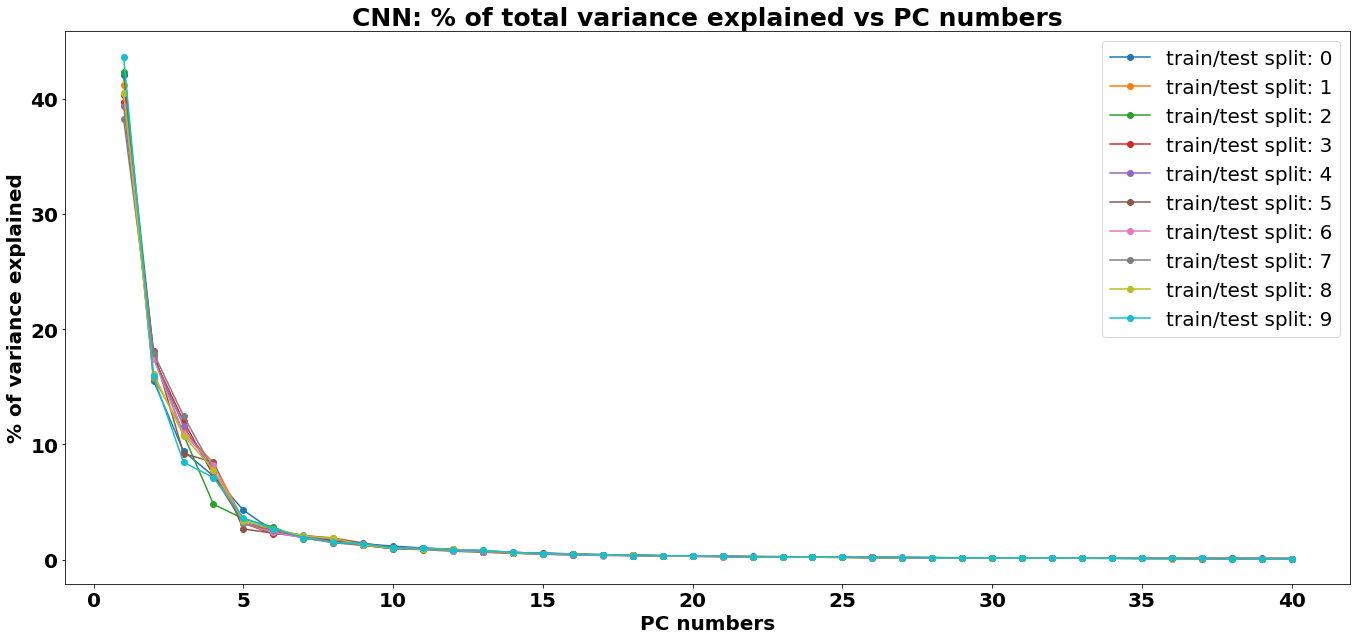

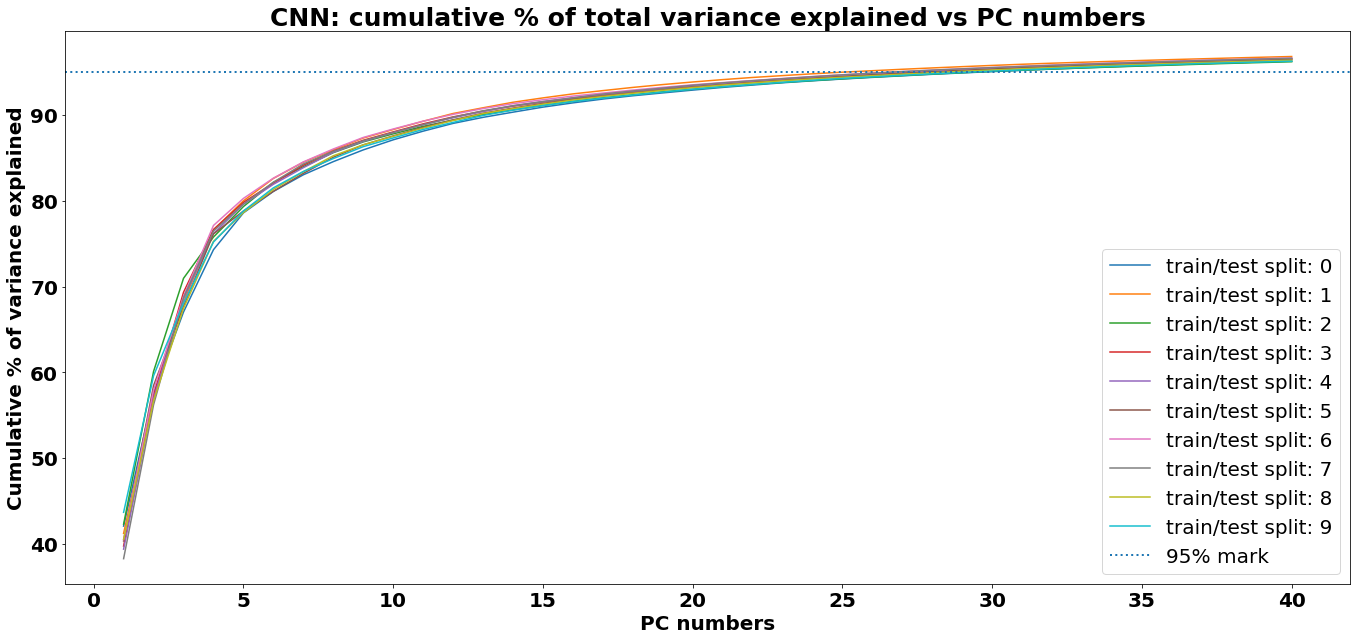

CNN: Mean 95th perc. cutoff: 27.3
cmb train/test fold: 0
cmb train/test fold: 1
cmb train/test fold: 2
cmb train/test fold: 3
cmb train/test fold: 4
cmb train/test fold: 5
cmb train/test fold: 6
cmb train/test fold: 7
cmb train/test fold: 8
cmb train/test fold: 9


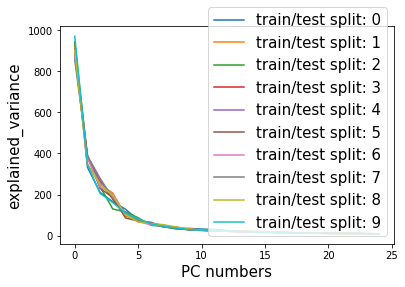

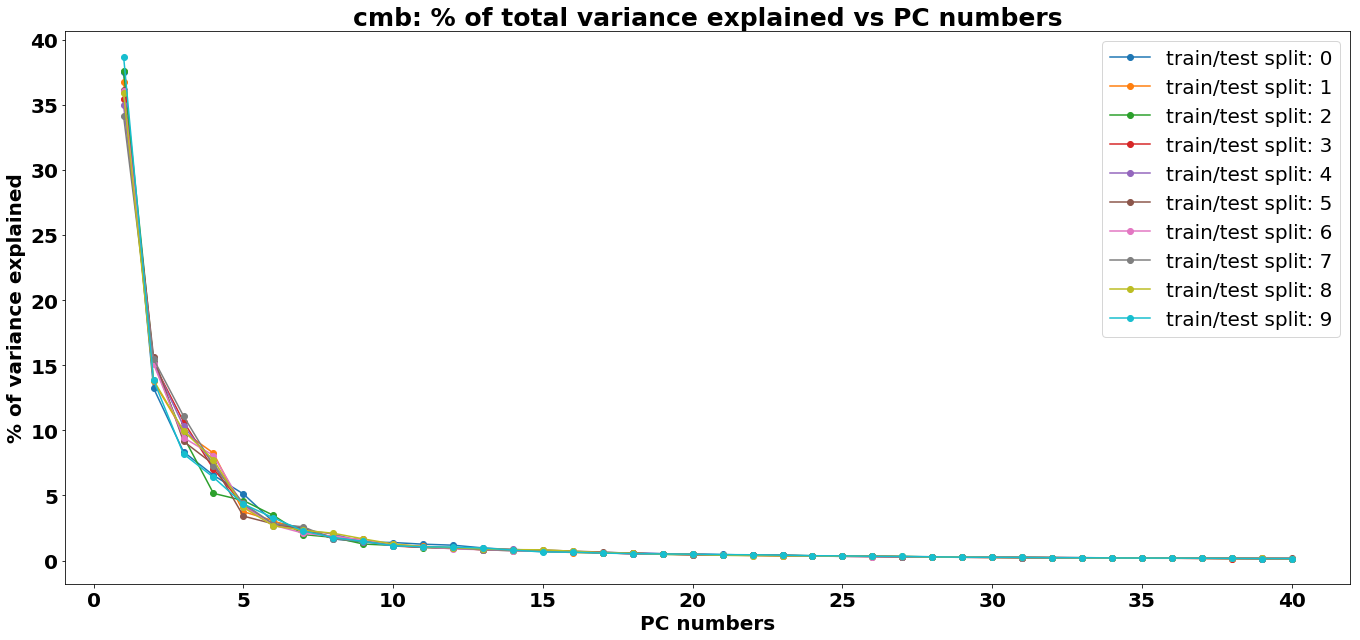

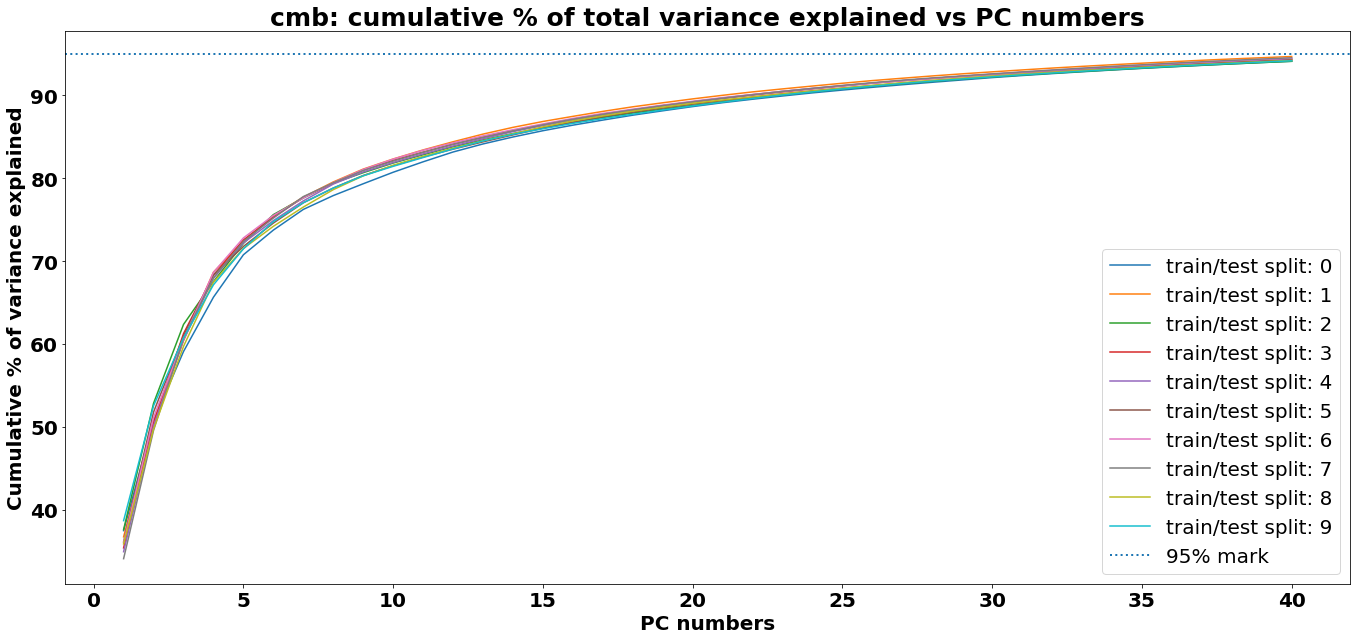

cmb: Mean 95th perc. cutoff: 44.4
texture train/test fold: 0
texture train/test fold: 1
texture train/test fold: 2
texture train/test fold: 3
texture train/test fold: 4
texture train/test fold: 5
texture train/test fold: 6
texture train/test fold: 7
texture train/test fold: 8
texture train/test fold: 9


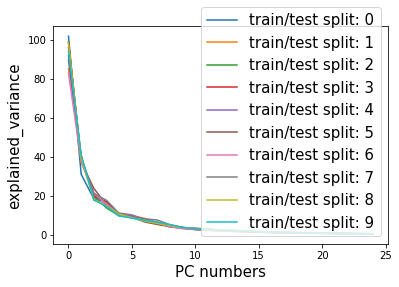

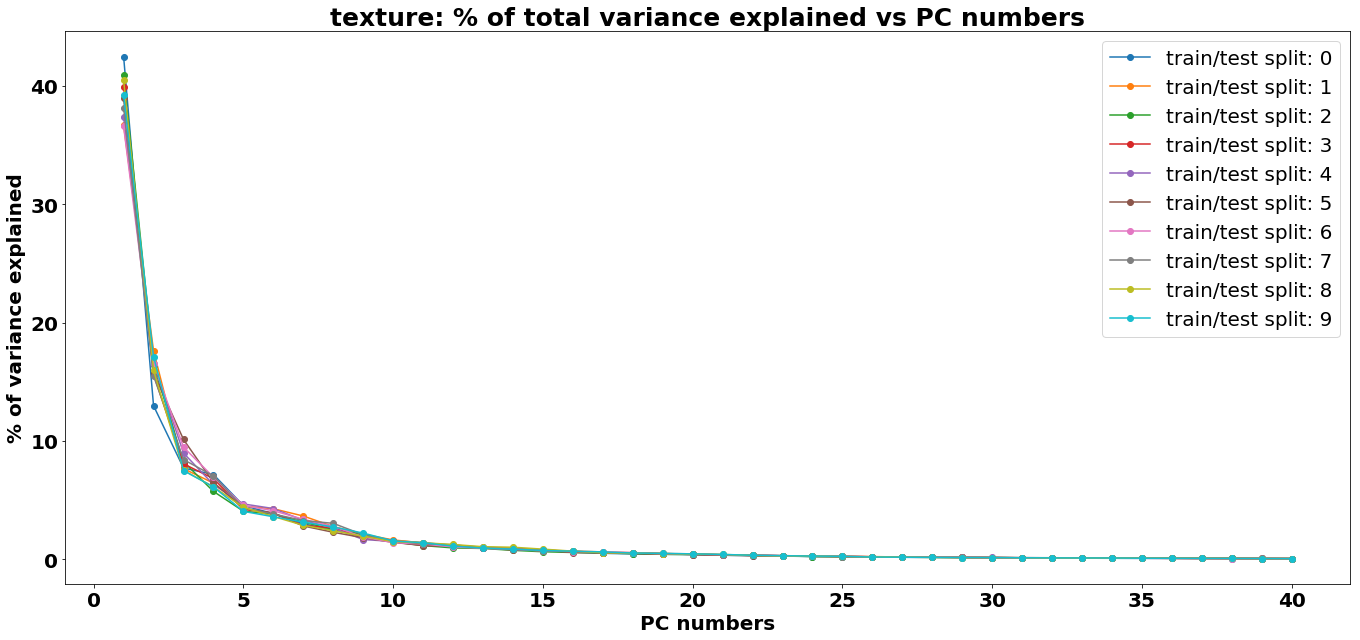

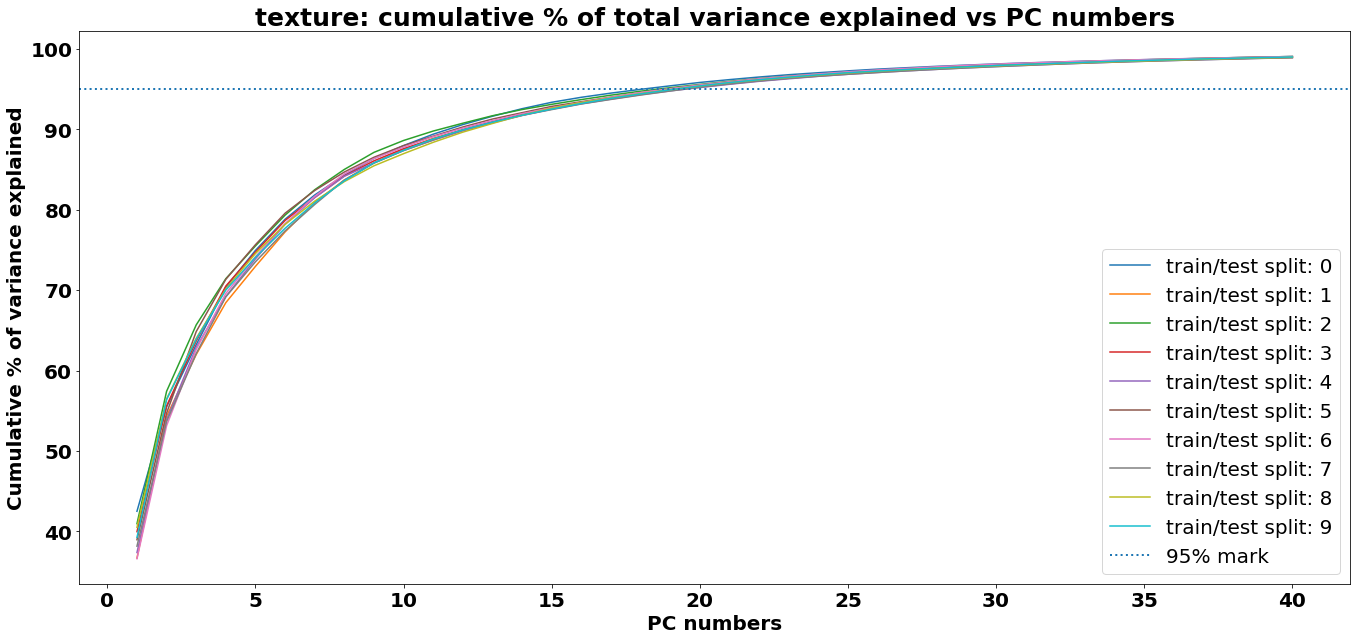

texture: Mean 95th perc. cutoff: 18.5
TDA train/test fold: 0
TDA train/test fold: 1
TDA train/test fold: 2
TDA train/test fold: 3
TDA train/test fold: 4
TDA train/test fold: 5
TDA train/test fold: 6
TDA train/test fold: 7
TDA train/test fold: 8
TDA train/test fold: 9


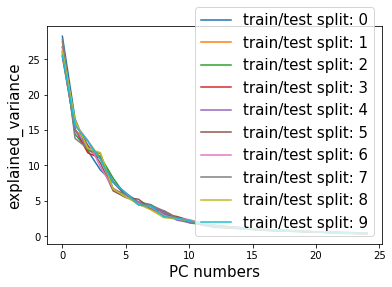

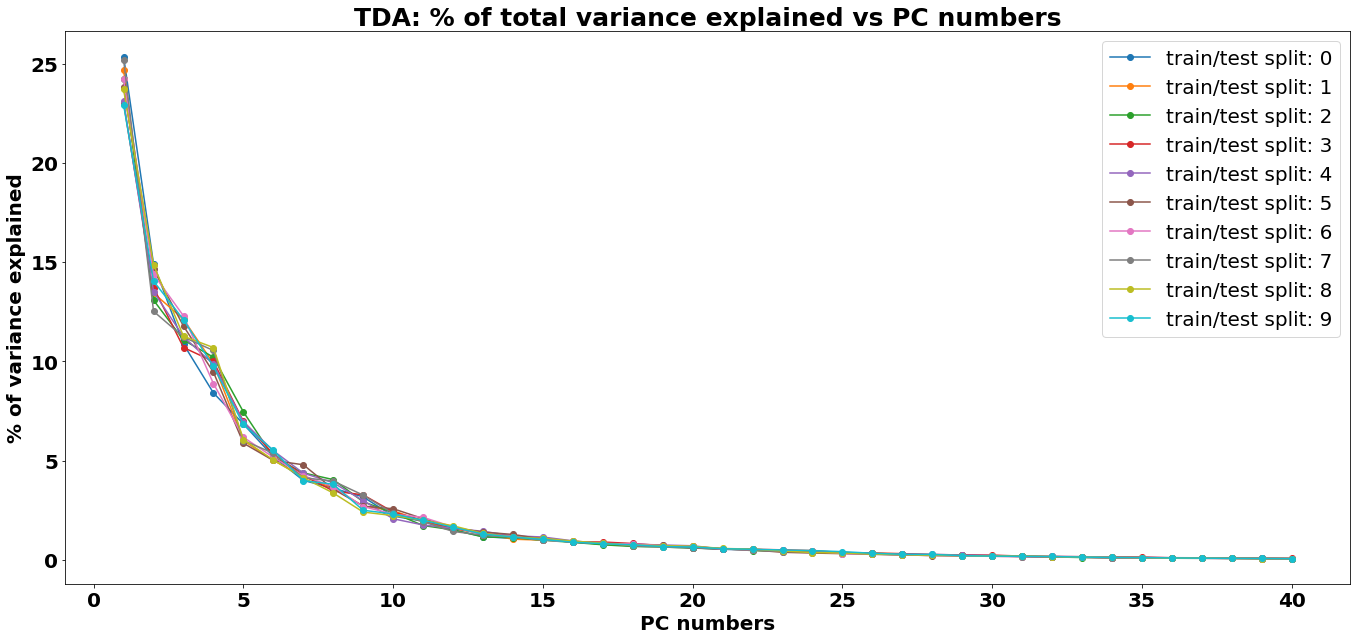

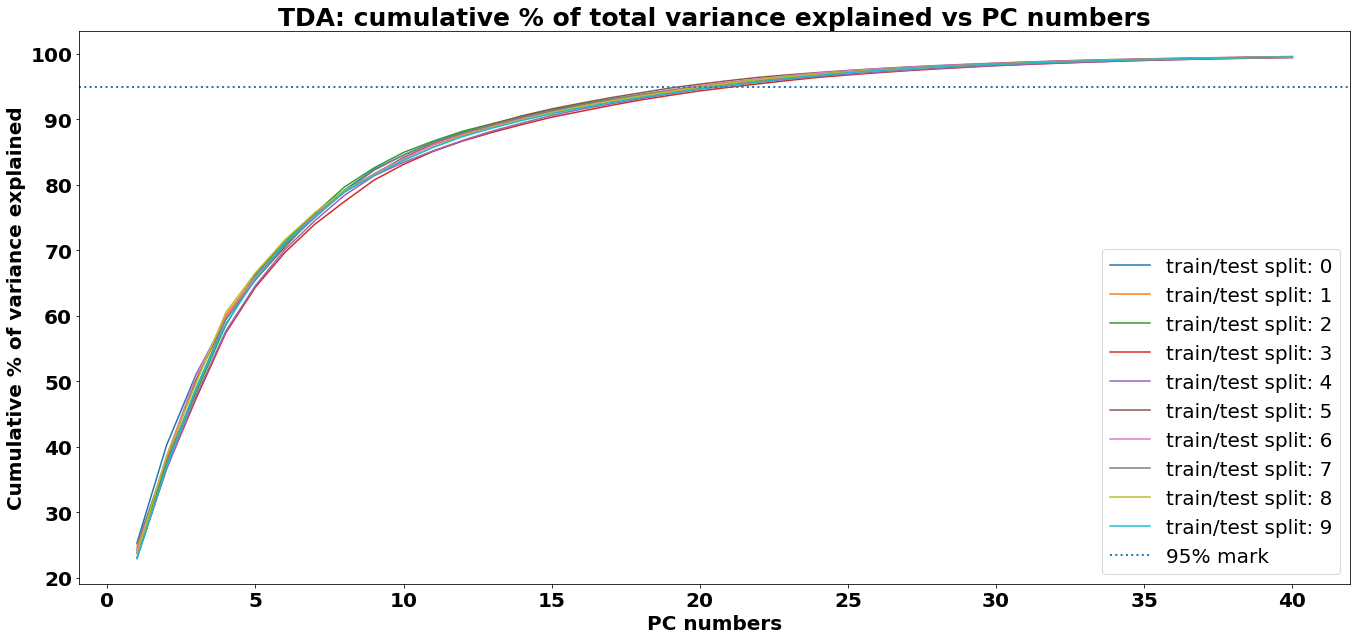

TDA: Mean 95th perc. cutoff: 19.6
CNN train/test fold: 0
CNN train/test fold: 1
CNN train/test fold: 2
CNN train/test fold: 3
CNN train/test fold: 4
CNN train/test fold: 5
CNN train/test fold: 6
CNN train/test fold: 7
CNN train/test fold: 8
CNN train/test fold: 9


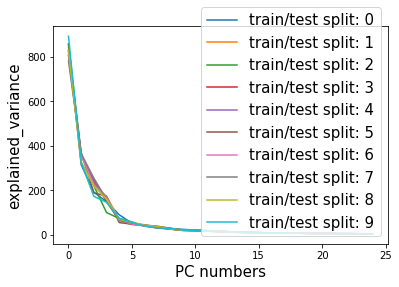

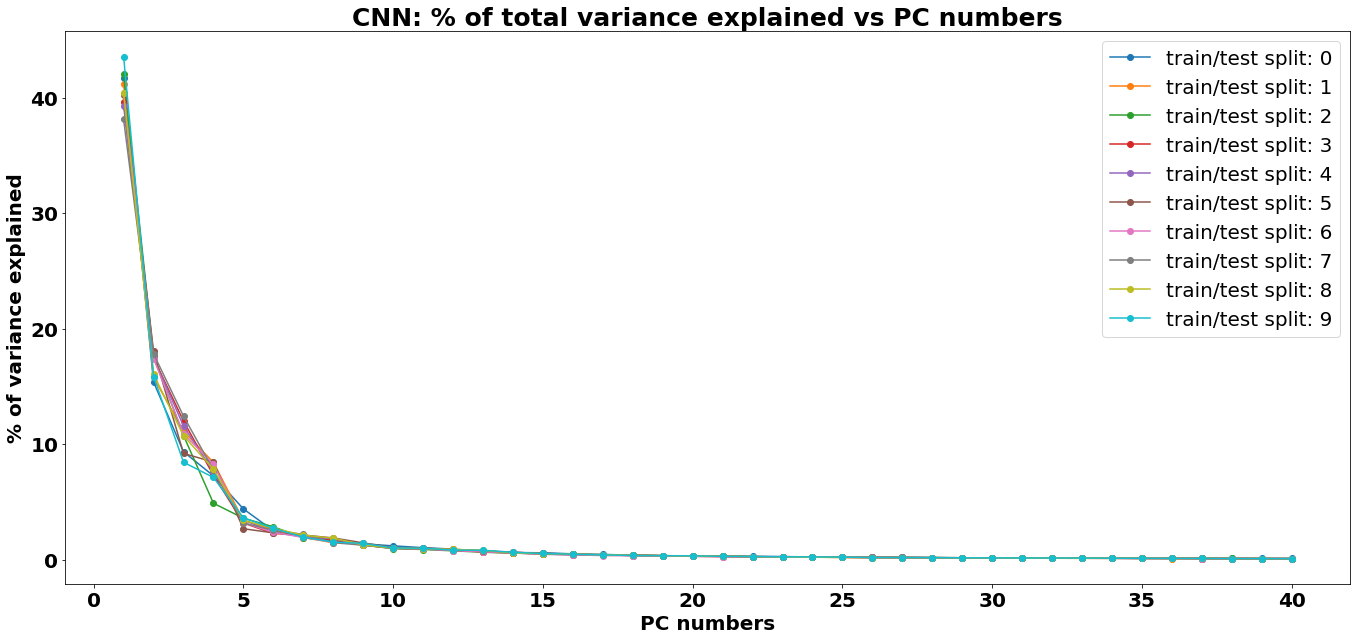

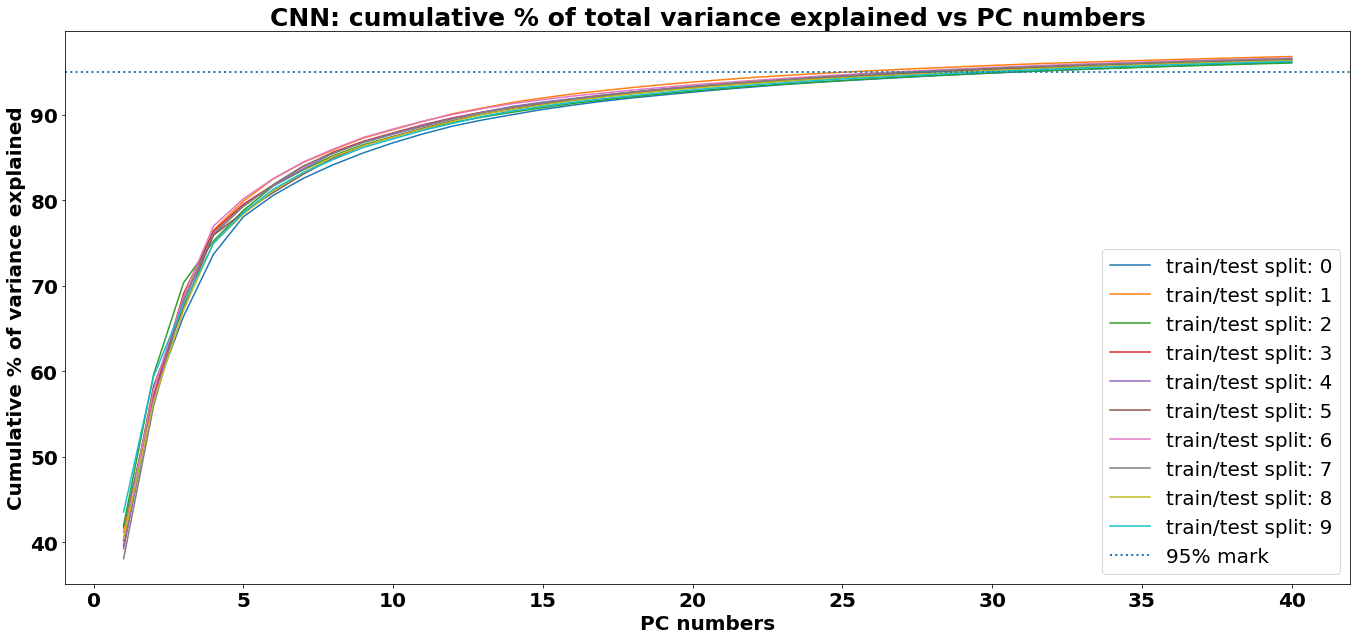

CNN: Mean 95th perc. cutoff: 27.9
cmb train/test fold: 0
cmb train/test fold: 1
cmb train/test fold: 2
cmb train/test fold: 3
cmb train/test fold: 4
cmb train/test fold: 5
cmb train/test fold: 6
cmb train/test fold: 7
cmb train/test fold: 8
cmb train/test fold: 9


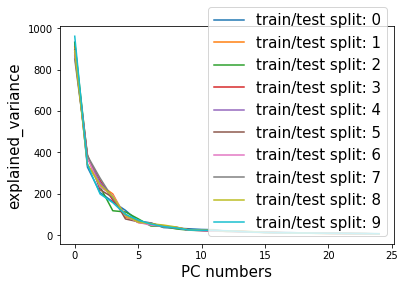

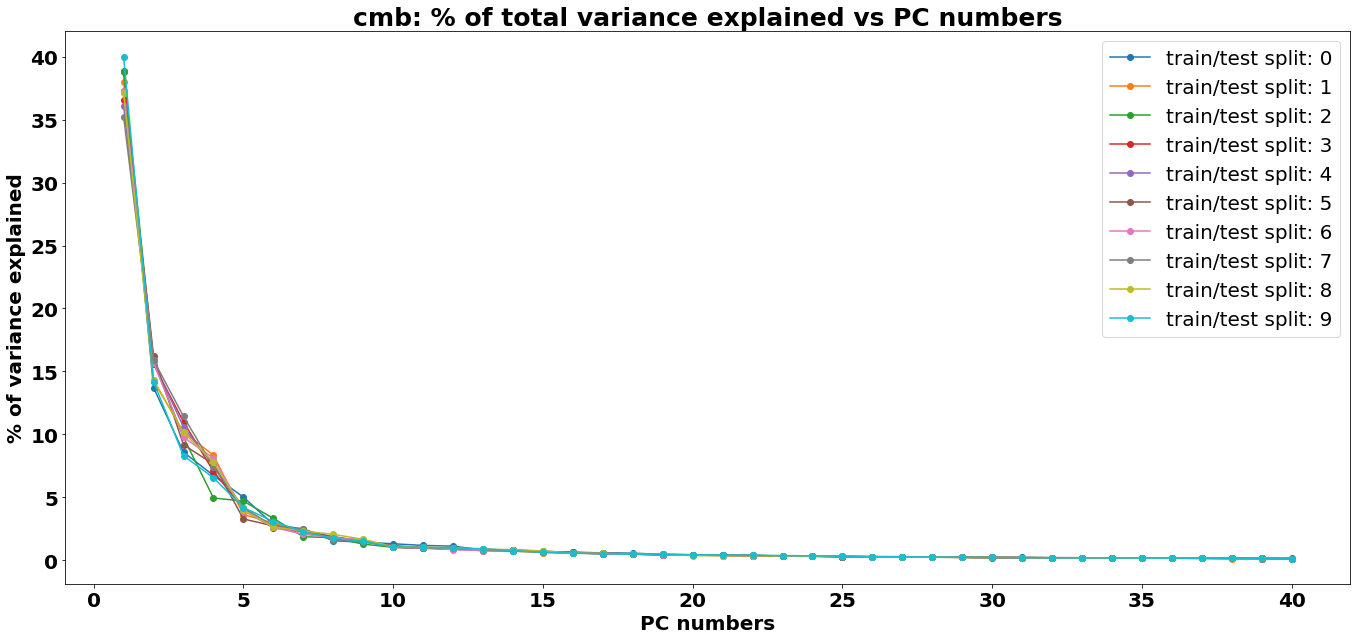

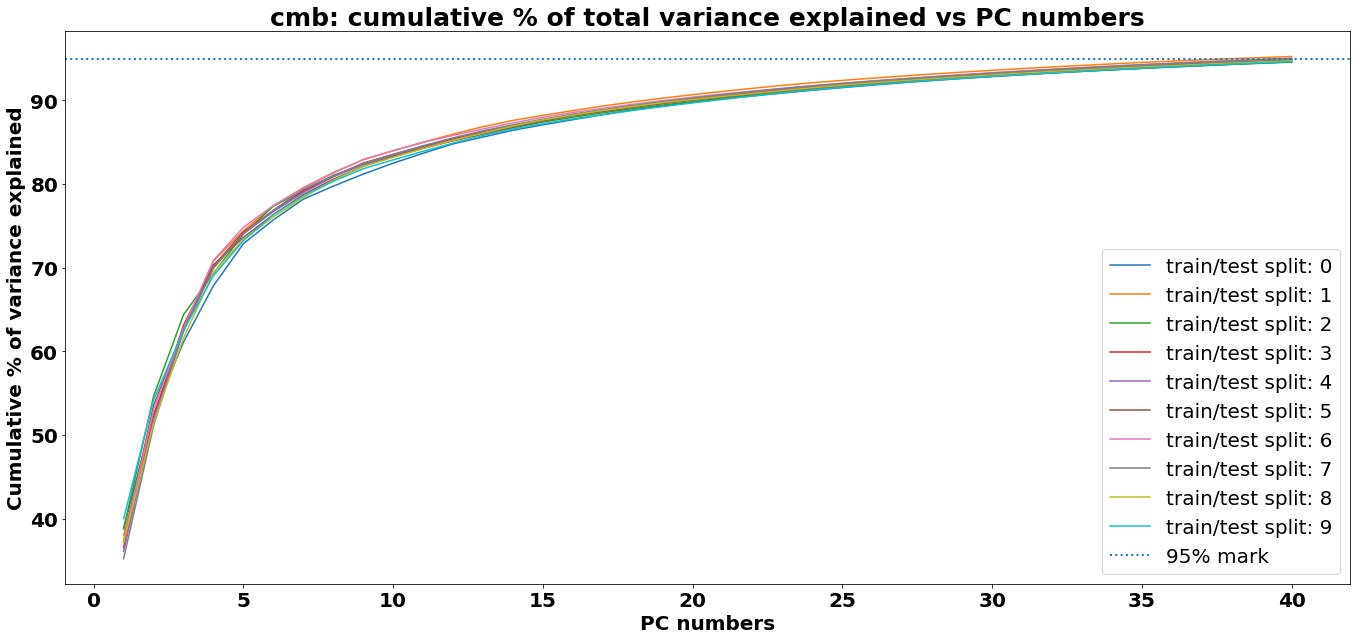

cmb: Mean 95th perc. cutoff: 40.6


In [2]:

modal_list = ['FLAIR','T1', 'T1post','T2']
# study_list = ['texture','TDA','CNN']
study_list = ['texture','TDA','CNN','cmb']
# study_list = ['cmb']
#study = 'CNN' # <== CHANGE HERE
ICC_filt = 3

for ICC_filt in (4,1):
    if ICC_filt == 1:
        suffix = '_icc2'
    elif ICC_filt >= 3:
        suffix = '_icc%i' % ICC_filt
    else: 
        suffix = '' 

    for study in study_list:

        (origdir,basedir,imagedir,normdir,splitdir,out_dir,model_dir) = file_structure.file_dirs(study)
        random_state_list = [2,4,6,8,10,12,14,16,18,20] 

        explained_variance_list = []
        prop_explained_variance_list = []
        cumsum_explained_variance_list = []
        cutoff_arr = np.empty(10)

        for fold in range(10):
            random_state = random_state_list[fold]

            (train_samples, _ , train_1p19q, train_age, train_KPS, train_gender, 
             train_id, train_fnames)= load_data.load_data('train',fold,study,ICC_filt)
            (val_samples, _ , val_1p19q, val_age, val_KPS, val_gender, 
             val_id, val_fnames)= load_data.load_data('val',fold,study,ICC_filt)
            (test_samples, _ , test_1p19q, test_age, test_KPS, test_gender, 
             test_id, test_fnames)= load_data.load_data('test',fold,study,ICC_filt)

            fold_dir = os.path.join(splitdir, 'fold_' + str(fold))
    #         if ICC_filt == 1:
    #             features_ICC = np.load(os.path.join(splitdir,'fold_' +str(fold),'texture_feature_minICC2.npy'))
    #             train_samples = train_samples[:,features_ICC > .75]
    #             val_samples = val_samples[:,features_ICC > .75]
    #             test_samples = test_samples[:,features_ICC > .75]
            print('%s train/test fold: %d' % (study, fold))


            # combine train and val
            train_val_samples = np.concatenate((train_samples,val_samples),axis=0)


            # standardize data
            scaler = StandardScaler()

            scaler.fit(train_val_samples)
            train_val_standardized = scaler.transform(train_val_samples)
            test_standardized = scaler.transform(test_samples)

            # instantiate PCA
            pca = PCA(random_state = random_state)
            pca.fit(train_val_standardized)

            explained_variance_list.append(pca.explained_variance_)
            prop_explained_variance_list.append(pca.explained_variance_ratio_)
            cumsum_explained_variance_list.append(pca.explained_variance_ratio_.cumsum())
            cutoff_arr[fold] =np.count_nonzero(cumsum_explained_variance_list[fold]<.95)

            # instantiate PCA to # elements
            pca = PCA(n_components = math.floor(cutoff_arr[fold])+1)
            pca.fit(train_val_standardized)

            # transform data
            pca_train_val = pca.transform(train_val_standardized)
            pca_test = pca.transform(test_standardized)

            # split train from val
            num_train = len(train_samples)

            pca_train = pca_train_val[0:num_train,:]
            pca_val = pca_train_val[num_train:,:]


            np.save(os.path.join(fold_dir,'train_%s_pca%s.npy' % (study.lower()[0:3], suffix)),pca_train)
            np.save(os.path.join(fold_dir,'val_%s_pca%s.npy' % (study.lower()[0:3], suffix)),pca_val)
            np.save(os.path.join(fold_dir,'test_%s_pca%s.npy' % (study.lower()[0:3], suffix)),pca_test) 

        # explained_variance vs n_components
        for ii in range(10):

            label_name = 'train/test split: ' + str(ii)
            plt.plot(explained_variance_list[ii][0:25], label = label_name )

        plt.xlabel('PC numbers', fontsize=15)
        plt.ylabel('explained_variance', fontsize=15)
        plt.legend(loc="lower right", fontsize = 15)
        plt.show()

        # explained_variance proportion vs n_components
        plt.figure(figsize = (19,9))

        for ii in range(10):

            label_name = 'train/test split: %d' % ii
            plt.plot(range(1,41),prop_explained_variance_list[ii][0:40]*100, '-o',label = label_name )

        plt.xlabel('PC numbers', fontsize=20, weight = 'bold')
        plt.ylabel(r'% of variance explained', fontsize=20, weight = 'bold')
        plt.legend(loc="upper right", fontsize = 20)
        plt.title(study + r': % of total variance explained vs PC numbers', fontsize = 25, weight = 'bold')
        plt.xticks(fontsize = 20, weight = 'bold')
        plt.yticks(fontsize = 20, weight = 'bold')
        plt.tight_layout()
        plt.savefig('%s variance_prop vs PC num.png' % study, bbox_inches = "tight")

        # explained_variance proportion vs n_components
        plt.figure(figsize = (19,9))
        for ii in range(10):

            label_name = 'train/test split: ' + str(ii)
            plt.plot(range(1,41),cumsum_explained_variance_list[ii][0:40]*100, label = label_name )



        plt.axhline(95, linestyle=':', label = r'95% mark', lw = 2)
        plt.xlabel('PC numbers', fontsize=20, weight = 'bold')
        plt.ylabel(r'Cumulative % of variance explained', fontsize=20, weight = 'bold')
        plt.legend(loc="lower right", fontsize = 20)
        plt.xticks(fontsize = 20, weight = 'bold')
        plt.yticks(fontsize = 20, weight = 'bold')
        plt.title('%s: cumulative %% of total variance explained vs PC numbers' % study, fontsize = 25, weight = 'bold')
        plt.tight_layout()
        plt.savefig(study + ' cumulative_pca.png', bbox_inches = "tight")

        plt.show()

        cutoff_95perc = np.mean(cutoff_arr)
        print('%s: Mean 95th perc. cutoff: %g' % (study, cutoff_95perc))
        # figure out how many components to explain 95% variance of the data. (Nick)